In [58]:
trace_file = '../out/sim/sequence_length5000/beast-relaxed-fixed.log'
tree_file = '../out/sim/sequence_length5000/beast-relaxed-fixed.trees'
beast_config_file = '../config/beast-config.yaml'
plot_out_file = '../out/sim/sequence_length5000/rate-correlations.png'

In [2]:
import pandas as pd
from treeflow_pipeline.util import yaml_input

renaming = {
    "TreeHeight": 'tree_height',
    "popSize": "pop_size", 
    "clockRate": "clock_rate",
    "Tree.treeLength": "tree_length"
}


beast_config = yaml_input(beast_config_file)
burn_in = beast_config['burn_in']

def remove_burn_in(x):
    return x[np.arange(len(x)) > int(len(trace) * burn_in)]

trace = (pd.read_table(trace_file, comment="#")
         .pipe(lambda x: x[list(renaming.keys())])
         .pipe(lambda x: x.rename(columns=renaming))
        )
trace

,tree_height,pop_size,clock_rate,tree_length
0,15.865310,15.604540,0.010761,38.797474
1,15.734642,5.601547,0.011701,37.829674
2,16.151335,6.624020,0.011395,39.364145
3,16.202086,4.181319,0.011566,38.997457
4,16.807179,5.072408,0.011039,41.067360
...,...,...,...,...
9996,16.769871,8.513815,0.010207,42.163139
9997,14.801463,5.978405,0.011245,37.066533
9998,16.064274,6.249105,0.010627,39.825459
9999,16.887560,6.350787,0.010295,43.108978


In [3]:
import dendropy

trees = dendropy.TreeList.get(path=tree_file, schema="nexus", rooting="default-rooted")

In [4]:
import numpy as np

def traverse_leaves_first(tree, f, out=None):
    taxon_count = len(tree.taxon_namespace)
    if out is None:
        out = np.zeros(2 * taxon_count - 1)
    leaf_index = 0
    node_index = taxon_count
    for node in tree.postorder_node_iter():
        if node.is_leaf():
            out[leaf_index] = f(node)
            leaf_index += 1
        else:
            out[node_index] = f(node)
            node_index += 1
    return out

taxon_count = len(trees[0].taxon_namespace)
blens = np.zeros((len(trees), 2 * taxon_count - 1))
rates = np.zeros((len(trees), 2 * taxon_count - 1))

for i, tree in enumerate(trees):
    traverse_leaves_first(tree, lambda x: x.edge.length, out=blens[i])
    traverse_leaves_first(tree, lambda x: float(x.annotations['rate'].value), out=rates[i])

blens[-3:], rates[-3:]

(array([[0.71899482, 5.10541554, 2.44292977, 1.22727111, 0.01780258,
         0.19790398, 1.49745253, 2.06001042, 8.00123281, 3.73758535,
         4.22386285, 0.03687616, 1.96650341, 1.35659619, 0.01374868,
         7.22127275, 0.        ],
        [1.13194903, 5.51836974, 2.67028129, 1.27651162, 0.06704308,
         0.40713382, 1.70223611, 2.30826586, 8.82451891, 3.60976292,
         4.38385219, 0.0324299 , 2.00997526, 1.33569227, 0.07152893,
         7.75942708, 0.        ],
        [0.85897805, 5.24539877, 2.09694549, 1.22426414, 0.01479561,
         0.28884592, 1.58564982, 1.9747155 , 7.27752825, 3.60196239,
         4.31781176, 0.03413151, 1.7930112 , 1.09590683, 0.36409323,
         6.49320792, 0.        ]]),
 array([[0.00972067, 0.00992967, 0.00882567, 0.01030918, 0.01052483,
         0.01569926, 0.0114289 , 0.00975338, 0.00966058, 0.00983638,
         0.01078431, 0.00946017, 0.01137363, 0.01035432, 0.01191912,
         0.01237899, 1.        ],
        [0.00793811, 0.01032645, 0

In [38]:
rates_scaled = rates / trace.clock_rate[:, np.newaxis]
mean_rate_b = remove_burn_in(trace.clock_rate)
rates_b = remove_burn_in(rates)[:, :-1]
rates_scaled_b = remove_burn_in(rates_scaled)[:, :-1]
blens_b = remove_burn_in(blens)[:, :-1]

In [39]:
distances = blens_b * rates_b
mean_distances = np.mean(distances, axis=0)
mean_distances

array([0.00766192, 0.05552311, 0.02182012, 0.0134833 , 0.00033124,
       0.00443489, 0.01864228, 0.02108845, 0.08545529, 0.03411215,
       0.04602183, 0.00041066, 0.02130853, 0.01141638, 0.0016955 ,
       0.07865821])

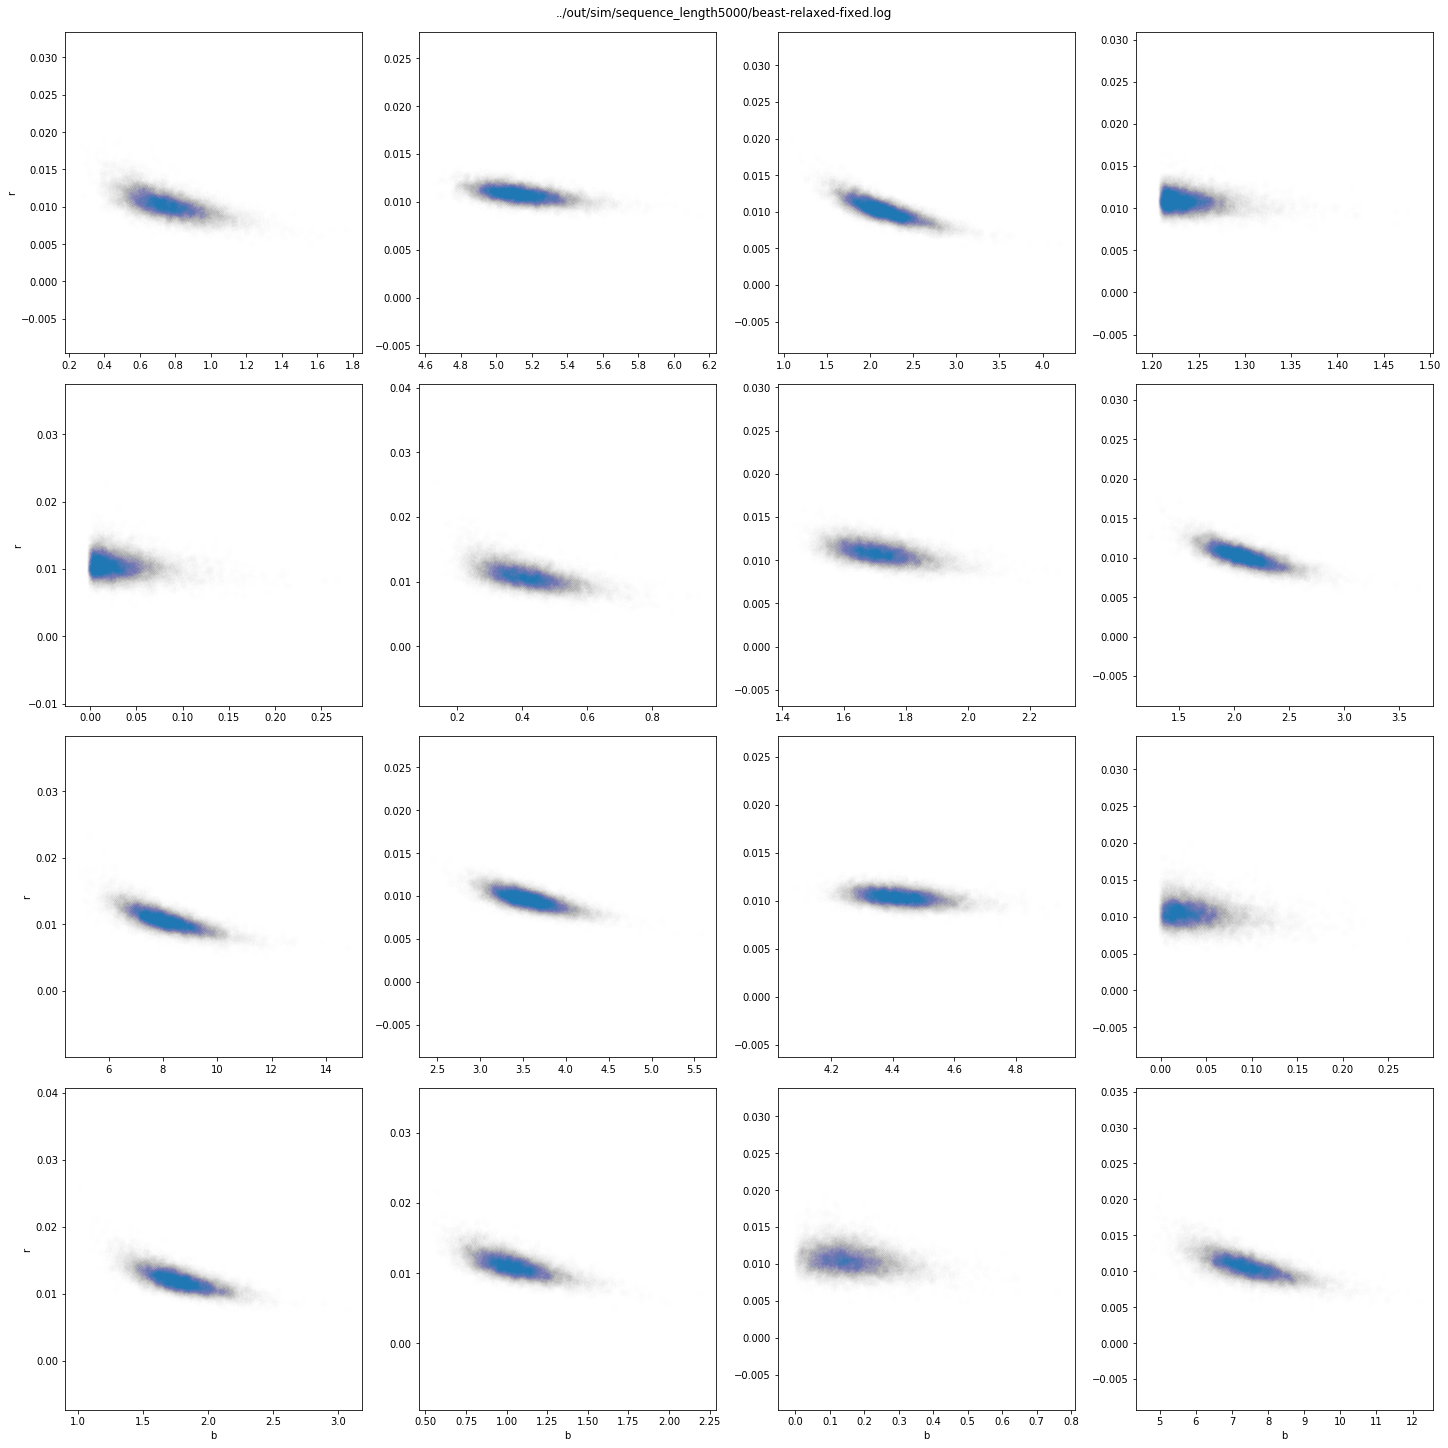

In [64]:
import matplotlib.pyplot as plt

n_cols = 4
n_branches = 2*taxon_count - 2
n_rows = n_branches // n_cols
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 5*n_rows), constrained_layout=True)
axs_flat = [ax for row in axs for ax in row]
for ax, mean_d, branch_blens, branch_rates in zip(axs_flat, mean_distances, blens_b.T, rates_b.T):
    ax.scatter(branch_blens, branch_rates, alpha=0.005)
    #xs = np.linspace(*np.quantile(branch_blens, [0.025, 0.975]), 50)
    #ax.plot(xs, mean_d / xs)

for ax in axs[-1]:
    ax.set_xlabel('b')

for row in axs:
    row[0].set_ylabel('r')
    
plt.suptitle(trace_file);
plt.savefig(plot_out_file)

In [49]:
# import tensorflow as tf
# import tensorflow_probability as tfp


# def get_scale_variable(name, shape):
#     return tfp.util.DeferredTensor(tf.Variable(tf.ones(shape), name=name), tf.nn.softplus)

# mean_field = tfp.distributions.JointDistributionNamed(dict(
#     branch_lengths = tfp.distributions.Independent(tfp.distributions.LogNormal(
#         loc=tf.Variable(tf.zeros(n_branches), name='mean_field_blen_loc'),
#         scale=get_scale_variable('mean_field_blen_scale', n_branches)
#     ), reinterpreted_batch_ndims=1),
#     rates = tfp.distributions.Independent(tfp.distributions.LogNormal(
#         tf.Variable(tf.zeros(n_branches), name='mean_field_rate_loc'), get_scale_variable('mean_field_rate_scale', n_branches)
#     ), reinterpreted_batch_ndims=1)
# ))

# mean_field.log_prob(mean_field.sample())

<tf.Tensor: shape=(), dtype=float32, numpy=-54.200596>

In [52]:
# data_dict = {
#     'branch_lengths': blens_b,
#     'rates': rates_b
# }

# def fit_approximation(approx):
#     return tfp.math.minimize(lambda: tf.reduce_sum(approx.log_prob(data_dict)), 10, tf.optimizers.SGD(learning_rate=0.001))

# res = fit_approximation(mean_field)